In [31]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import requests
import zipfile
from pathlib import Path
import os

import random
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

from typing import Tuple, Dict, List

try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

In [32]:
data_path = Path("data/")
image_path = data_path / "images"

if image_path.is_dir():
    print("Images already downloaded")
else:
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak and sushi data...")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  zip_ref.extractall(image_path)

Images already downloaded


In [33]:
# Function for walking through our directory paths and collecting all images
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# Writing a helper function to get class names
def get_class_names(target_directory: str) -> Tuple[List[str], Dict[str, int]]:
  class_names_found = sorted([entry.name for entry in os.scandir(target_directory) if entry.is_dir()])

  if not class_names_found:
    raise FileNotFoundError(f"No directories found in {target_directory}")

  class_to_idx = {class_name: i for i, class_name in enumerate(class_names_found)}
  return class_names_found, class_to_idx

# Training and testing directories
train_dir = image_path / "train"
test_dir = image_path / "test"

In [34]:
# Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str]=None,
                          n: int=10,
                          display_shape: bool=True,
                          seed: int=None):
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10")

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)
  plt.figure(figsize=(16, 8))

  for i, target_sample in enumerate(random_samples_idx):
    img, label = dataset[target_sample][0], dataset[target_sample][1]
    img_adjust = img.permute(1, 2, 0)
    plt.subplot(1, n, i + 1)
    plt.imshow(img_adjust)
    plt.axis(False)

    if classes:
      plt.title(classes[label])
    if display_shape:
      print(f"Image shape: {img_adjust.shape}")

In [35]:
# Functionizing our training loop
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimzer: torch.optim.Optimizer,
               loss_list,
               acc_list):
  # Initialize loss and accuracy
  train_loss, acc = 0, 0

  #Set model to training mode
  model.train()

  # Loop through the training batches
  for X, y in dataloader:
    # 1. Forward pass
    y_pred = model(X)

    # 2. Aaccumulate loss and accuracy
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    acc += (y_pred.argmax(dim=1) == y).sum().item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Adjust metrics
  train_loss /= len(dataloader)
  acc /= len(dataloader.dataset)
  loss_list.append(train_loss)
  acc_list.append(acc)

  # Print results
  print(f"Train loss: {train_loss:.4f} | Train acc: {acc:.4f}")

In [36]:
# Functionalizing our testing loop
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              loss_list,
              acc_list):
  # Initialize loss and accuracy
  loss, acc = 0, 0

  # Set model to eval mode
  model.eval()

  # Turn on inference mode
  with torch.inference_mode():
    for X, y in dataloader:
      y_pred = model(X)

      # Accumulate loss and accuracy
      loss += loss_fn(y_pred, y)
      acc += (y_pred.argmax(dim=1) == y).sum().item()

    # Adjust metrics
    loss /= len(dataloader)
    acc /= len(dataloader.dataset)
    loss_list.append(loss)
    acc_list.append(acc)

  # Print results
  print(f"Test loss: {loss:.4f} | Test acc: {acc:.4f}")

In [37]:
# Create an eval function to avoid rewriting the evaluation step
# Returns a dictionary containing results of the model predicting on data_loader
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += (y_pred.argmax(dim=1) == y).sum().item()

    loss /= len(dataloader)
    acc /= len(dataloader.dataset)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

In [38]:
"""
Create a custom dataset to replicate ImageFolder
1. Subclass torch.utils.data.Dataset
2. Init our subclass with target directory (and transform if we want to transform our data)
3. Create several attributes:
  - paths of our images
  - transforms we would like to see
  - list of target classes
  - class to index mapping
4. Create a function to load images
5. Implement __len__ and __getitem__ methods
"""
class ImageFolderCustom(Dataset):
  def __init__(self, target_directory: str, transform=None, duplicate=0):
    self.class_names, self.class_to_idx = get_class_names(target_directory)
    self.target_directory = target_directory
    self.transform = transform
    self.paths = list(Path(target_directory).glob("*/*.jpg")) # Get all image paths

    temp = self.paths.copy()
    for i in range(duplicate):
      self.paths += temp # Duplicate paths

  # Return number of images
  def __len__(self):
    return len(self.paths)

  # Return image based on path index
  def load_image(self, index):
    img_path = self.paths[index]
    return Image.open(img_path)

  # This function returns one sample of data (torch tensor and label)
  def __getitem__(self, index: int):
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]
    if self.transform:
      img = self.transform(img)
    return img, class_idx

In [39]:
# Model our CNN architecture
class CustomNetwork(nn.Module):
  def __init__(self, input_shape: int, output_shape: int):
    super().__init__()
    self.conv_blocks = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=12,
                  kernel_size=3,
                  padding=0,
                  stride=1),
        nn.ReLU(),

        nn.Conv2d(in_channels=12,
                  out_channels=12,
                  kernel_size=3,
                  padding=0,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=12,
                  out_channels=12,
                  kernel_size=3,
                  padding=0,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=12 * 14 * 14,
                  out_features=12),
        nn.ReLU(),
        nn.Linear(in_features=12,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_blocks(x)
    #print(x.shape)
    x = self.classifier(x)
    return x

In [40]:
# Transforming images into tensors - data augmentation
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.RandomPerspective(p=0.5),
    transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Test our custom image folder
train_custom_data = ImageFolderCustom(train_dir, transform=train_transform, duplicate=2)
test_custom_data = ImageFolderCustom(test_dir, transform=test_transform, duplicate=0)

# Turn custom images into DataLoaders
train_custom_dataloader = DataLoader(dataset=train_custom_data, batch_size=32, shuffle=True)
test_custom_dataloader = DataLoader(dataset=test_custom_data, batch_size=32, shuffle=True)

In [41]:
# Class names
class_names = train_custom_dataloader.dataset.class_names

# Instantiate our model
model_0 = CustomNetwork(input_shape=3, output_shape=len(class_names)).to("cpu")

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.0005, weight_decay=1e-5) #L2 regularization with weight_decay

model_0(torch.randn([1, 3, 64, 64]))

tensor([[-0.2363, -0.2918, -0.0985]], grad_fn=<AddmmBackward0>)

In [ ]:
# Set manual seed
torch.manual_seed(50)

# Lists for plotting loss/accuracy curves
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

# Train and test data
EPOCHS = 500
for epoch in range(EPOCHS):
  print(f"\nEpoch: {epoch + 1}\n---------")
  train_step(model_0, train_custom_dataloader, loss_fn, optimizer, train_loss_list, train_acc_list)
  test_step(model_0, test_custom_dataloader, loss_fn, test_loss_list, test_acc_list)


Epoch: 1
---------
Train loss: 1.1006 | Train acc: 0.2889
Test loss: 1.0976 | Test acc: 0.3333

Epoch: 2
---------
Train loss: 1.0948 | Train acc: 0.3437
Test loss: 1.0932 | Test acc: 0.3467

Epoch: 3
---------
Train loss: 1.0752 | Train acc: 0.4237
Test loss: 1.0961 | Test acc: 0.3600

Epoch: 4
---------
Train loss: 1.0616 | Train acc: 0.4504
Test loss: 1.0503 | Test acc: 0.4000

Epoch: 5
---------
Train loss: 1.0299 | Train acc: 0.4622
Test loss: 1.0329 | Test acc: 0.4133

Epoch: 6
---------
Train loss: 0.9807 | Train acc: 0.4978
Test loss: 0.9959 | Test acc: 0.4267

Epoch: 7
---------
Train loss: 1.0026 | Train acc: 0.4844
Test loss: 0.9797 | Test acc: 0.4133

Epoch: 8
---------
Train loss: 0.9779 | Train acc: 0.4785
Test loss: 0.9648 | Test acc: 0.4400

Epoch: 9
---------
Train loss: 0.9755 | Train acc: 0.5096
Test loss: 1.0077 | Test acc: 0.4667

Epoch: 10
---------
Train loss: 0.9898 | Train acc: 0.4978
Test loss: 0.9673 | Test acc: 0.4533

Epoch: 11
---------
Train loss: 0.9479

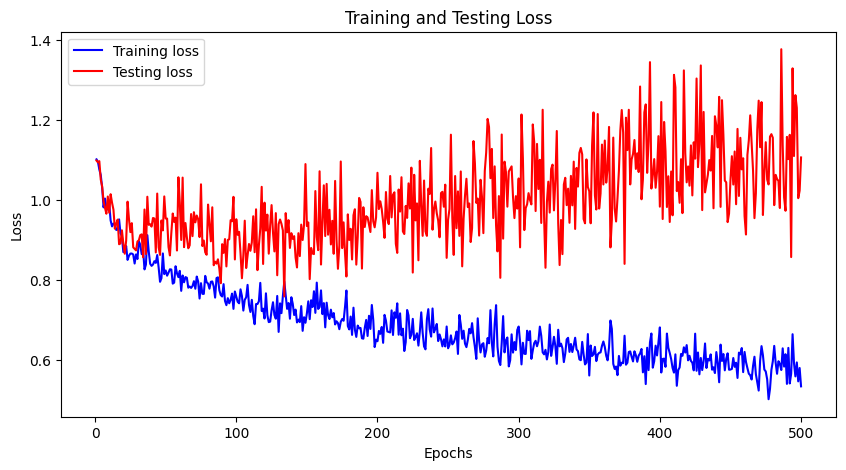

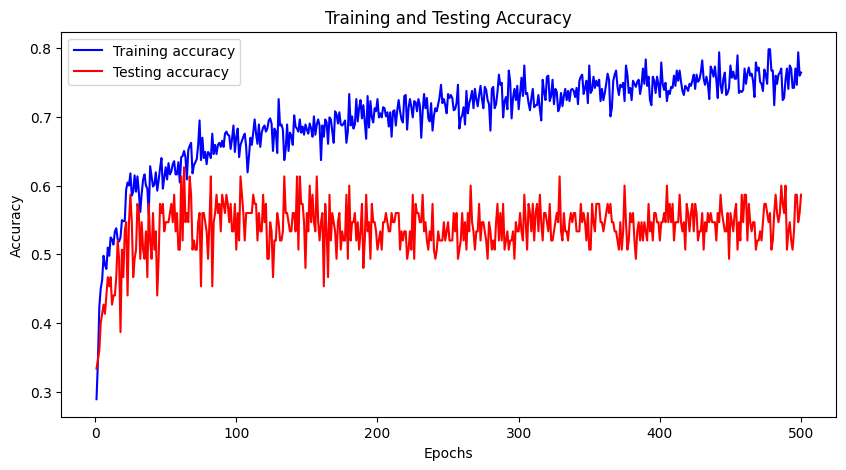

In [ ]:
# Epoch list
epoch_list = range(1, EPOCHS + 1)

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(epoch_list, train_loss_list, 'b', label='Training loss')
plt.plot(epoch_list, test_loss_list, 'r', label='Testing loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(epoch_list, train_acc_list, 'b', label='Training accuracy')
plt.plot(epoch_list, test_acc_list, 'r', label='Testing accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
#display_random_images(test_custom_data, classes=class_names, n=10)